In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport util

In [3]:
import numpy as np
import cupy as cp
import cuml
from sklearn.model_selection import KFold

from util import get_data, plot_activations

In [24]:
train_cross_X, train_cross_y, test_cross_X, test_cross_y = get_data("cross", "val", split_participants=True)
train_cross_X.shape, train_cross_y.shape

((2, 32, 248, 35624), (2, 32))

In [5]:
assert train_cross_X.shape == (2, 32, 248, 35624), f"train_cross_X.shape: {train_cross_X.shape}"
assert train_cross_y.shape == (2, 32), f"train_cross_y.shape: {train_cross_y.shape}"

In [6]:
test_cross_X.shape, test_cross_y.shape

((2, 16, 248, 35624), (2, 16))

In [50]:
assert test_cross_X.shape == (2, 16, 248, 35624)
assert test_cross_y.shape == (2, 16)

In [51]:
class_names = set(train_cross_y[0])
class_names

{'rest', 'task_motor', 'task_story_math', 'task_working_memory'}

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Store the original shape
original_train_shape = train_cross_y.shape
original_test_shape = test_cross_y.shape

# Apply LabelEncoder to the flattened arrays
train_cross_y_encoded = label_encoder.fit_transform(train_cross_y.flatten())
test_cross_y_encoded = label_encoder.transform(test_cross_y.flatten())

# Reshape back to the original shape
train_cross_y = train_cross_y_encoded.reshape(original_train_shape)
test_cross_y = test_cross_y_encoded.reshape(original_test_shape)

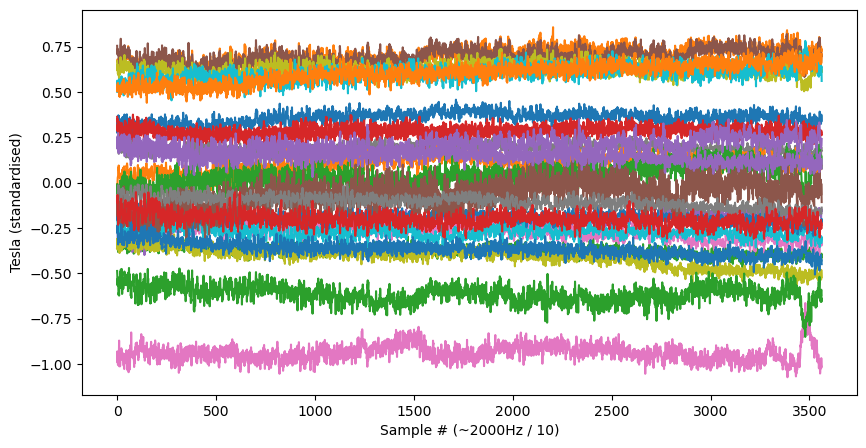

In [22]:
from matplotlib import pyplot as plt

# Downsample rate (just for graph)
downsample = 10

# Create a figure and axis
_, ax = plt.subplots(figsize=(10, 5))

# Plotting each dimension (sensor) separately
for i in range(0, train_cross_X.shape[2], 10):  # Looping over the first two dimensions
    ax.plot(train_cross_X[0, 0, i, ::downsample], label=f"Sensor {i+1}")

# Setting labels and title
ax.set_xlabel(f"Sample # (~2000Hz / {downsample})")
ax.set_ylabel("Tesla (standardised)")

# Display the plot
plt.show()

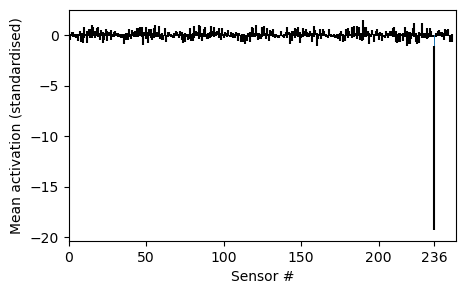

Sensors with absolute mean >1.5: (array([236]),)


In [32]:
plot_activations(train_cross_X[0])

In [8]:
train_cross_X = np.delete(train_cross_X, 236, axis=2)
test_cross_X = np.delete(test_cross_X, 236, axis=2)

In [10]:
from sklearn.decomposition import PCA

def perform_pca(data: np.ndarray, n_components = None):
    reshaped = data.reshape(-1, data.shape[-1])
    
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(reshaped)

    return pca, principal_components

In [14]:
pca_results, pca_components = perform_pca(train_cross_X, n_components=1000)

In [15]:
print(f"Explained variance: {np.sum(pca_results.explained_variance_ratio_):.5%}\n"
      f"Number of components: {pca_results.n_components_}")

Explained variance: 99.89289%
Number of components: 1000


In [16]:
# (Below are copied from intra, and aren't as accurate for cross, but you get the picture)
# 10   features, 99.580% variance explained
# 100  features, 99.825% variance explained
# 250  features, 99.905% variance explained
# 1000 features, 99.968% variance explained

# Below are for cross
# 10   features, 99.167% variance explained
# 100  features, 99.560% variance explained
# 250  features, 99.731% variance explained
# 1000 features, 99.893% variance explained

In [9]:
import time


def get_pca(data: np.ndarray, n_components=10):
    print("PCAing...")
    t = time.time()
    pca = PCA(n_components=n_components).fit(data)
    print(f"PCA done in {time.time() - t:.2f}s")
    return pca

In [18]:
def logistic_regression_pcad_train(X_train, y_train, n_components=10):
    # Reshape to 2D array, still keeping each column as a sample/feature, to be able to perform PCA. e.g. (32, 248, 35624) -> (32 * 248, 35624)
    reshaped_X_train = X_train.reshape(-1, X_train.shape[-1]).astype(np.float32)

    # Perform PCA on the reshaped data.
    pca = get_pca(reshaped_X_train, n_components=n_components)
    X_train_pcad = pca.transform(reshaped_X_train)
    
    # Shape to a 2D array adept to LogisticRegression, separating back into individual training points.
    # e.g. (32 * 248, 10) -> (32, 2480)
    reshaped_X_train = X_train_pcad.reshape(X_train.shape[0] * X_train.shape[1], -1)

    model = LogisticRegressionSklearn(random_state=0)
    model.fit(reshaped_X_train, y_train.flatten())

    return pca, model

In [19]:
def logistic_regression_pcad_test(X_test, y_test, pca, model) -> float:
    reshaped_X_val = X_test.reshape(-1, X_test.shape[-1]).astype(np.float32)
    X_val_pcad = pca.transform(reshaped_X_val)
    reshaped_X_val = X_val_pcad.reshape(X_test.shape[0] * X_test.shape[1], -1)

    return model.score(reshaped_X_val, y_test.flatten())

In [20]:
from sklearn.linear_model import LogisticRegression as LogisticRegressionSklearn

def logistic_regression_pcad_run(X: np.ndarray, y: np.ndarray, n_splits=5, n_components=10):
    scores = []
    kfold = KFold(n_splits=n_splits, shuffle=True)
    
    for train_index, val_index in kfold.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        pca, model = logistic_regression_pcad_train(X_train, y_train, n_components)
        
        score = logistic_regression_pcad_test(X_val, y_val, pca, model)
        scores.append(score)

    return sum(scores) / len(scores), scores

In [21]:
pca, model = logistic_regression_pcad_train(train_cross_X[:, :, :, :], train_cross_y, n_components=10)

score = logistic_regression_pcad_test(test_cross_X[:, :, :, :], test_cross_y, pca, model)

In [22]:
print(f"Accuracy for Logistic Regression with 10 (or 100, it's the same) principal components:\n"
      f"{score:.1%}")

Accuracy for Logistic Regression with 10 (or 100, it's the same) principal components:
62.5%


In [23]:
from cuml import LogisticRegression


def logistic_regression_train(X: np.ndarray, y: np.ndarray):
    X = cp.asarray(X.reshape(X.shape[0] * X.shape[1], -1).astype(np.float32))
    y = cp.asarray(y.flatten())
    
    model = LogisticRegression()
    
    model.fit(X, y)
    
    return model

In [24]:
def logistic_regression_test(X: np.ndarray, y: np.ndarray, model):
    X = cp.asarray(X.reshape(X.shape[0] * X.shape[1], -1).astype(np.float32))
    y = cp.asarray(y.flatten())
    
    y_pred = model.predict(X)
    
    cm = cuml.metrics.confusion_matrix(y, y_pred)
    accuracy = cp.mean(y == y_pred)
    
    return accuracy, cm

In [25]:
model = logistic_regression_train(train_cross_X[:, :, :, :], train_cross_y)

[W] [16:23:42.614691] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


In [26]:
score, cm = logistic_regression_test(test_cross_X[:, :, :, :], test_cross_y, model)

In [27]:
print(f"Accuracy for Logistic Regression on all features:\n"
      f"Accuracy: {score:.1%}")

Accuracy for Logistic Regression on all features:
Accuracy: 50.0%


In [28]:
import pandas as pd

class_names = label_encoder.inverse_transform(range(len(label_encoder.classes_)))
pd.DataFrame(cp.asnumpy(cm), index=class_names, columns=class_names)

,rest,task_motor,task_story_math,task_working_memory
rest,5,0,0,3
task_motor,0,4,4,0
task_story_math,0,4,4,0
task_working_memory,1,0,4,3


In [43]:
# import cupy
# 
# import gc
# 
# gc.collect()
# # run weird cuml command to free memory
# cupy.get_default_memory_pool().free_all_blocks()

In [13]:
from cuml.svm import SVC

def svm_train(X: np.ndarray, y: np.ndarray):
    X = cp.asarray(X.reshape(X.shape[0] * X.shape[1], -1).astype(np.float32))
    y = cp.asarray(y.flatten())
    
    model = SVC(C=1.0, kernel="rbf", gamma="scale")
    
    model.fit(X, y)
    
    return model

In [31]:
def svm_test(X: np.ndarray, y: np.ndarray, model):
    X = cp.asarray(X.reshape(X.shape[0] * X.shape[1], -1).astype(np.float32))
    y = cp.asarray(y.flatten())
    
    y_pred = model.predict(X)
    
    cm = cuml.metrics.confusion_matrix(y, y_pred)
    accuracy = cp.mean(y == y_pred)
    
    return accuracy, cm

In [32]:
model = svm_train(train_cross_X[:, :, :, ::2], train_cross_y)

In [33]:
score, cm = svm_test(test_cross_X[:, :, :, ::2], test_cross_y, model)

In [34]:
print(f"Accuracy: {score:.1%}")

Accuracy: 56.2%


In [15]:
def svm_grid_search(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):
    reshaped_X_train = X_train.reshape(-1, X_train.shape[-1]).astype(np.float32)

    # Perform PCA on the reshaped data.
    pca = get_pca(reshaped_X_train, n_components=100)  # Even just 10 works
    X_train_pcad = pca.transform(reshaped_X_train)
    
    reshaped_X_train = X_train_pcad.reshape(X_train.shape[0] * X_train.shape[1], -1)
    
    reshaped_X_val = X_val.reshape(-1, X_val.shape[-1]).astype(np.float32)
    X_val_pcad = pca.transform(reshaped_X_val)
    X_val = X_val_pcad.reshape(X_val.shape[0] * X_val.shape[1], -1)
    
    X_train = cp.asarray(reshaped_X_train)
    y_train = cp.asarray(y_train.flatten())
    
    X_val = cp.asarray(X_val)
    y_val = cp.asarray(y_val.flatten())

    param_grid = {
        # 'C': [1, 5, 10, 50, 100, 500, 1000],
        # 'kernel': ['rbf', 'sigmoid'],
        'C': [5],
        'kernel': ['rbf'],
    }

    grid_scores = {}
    for C in param_grid['C']:
        for kernel in param_grid['kernel']:
            model = SVC(C=C, kernel=kernel)
            model.fit(X_train, y_train)

            score = model.score(X_val, y_val)
            grid_scores[(C, kernel, None)] = score
            print(f"C: {C}, kernel: {kernel}, score: {score:.1%}")

    best_params = max(grid_scores, key=grid_scores.get)
    best_score = grid_scores[best_params]
    
    print(f"\nBest Parameters: {best_params}")
    print(f"Best Score: {best_score:.1%}")
    
    return grid_scores

In [16]:
grid_scores = svm_grid_search(train_cross_X[:, :, :, :], train_cross_y, test_cross_X[:, :, :, :], test_cross_y)

PCAing...
PCA done in 8.17s
C: 5, kernel: rbf, score: 100.0%

Best Parameters: (5, 'rbf', None)
Best Score: 100.0%


In [38]:
sorted(grid_scores.items(), key=lambda kv: kv[1], reverse=True)

[((5, 'rbf', None), 0.65625),
 ((10, 'rbf', None), 0.65625),
 ((50, 'rbf', None), 0.65625),
 ((100, 'rbf', None), 0.65625),
 ((500, 'rbf', None), 0.65625),
 ((1000, 'rbf', None), 0.65625),
 ((1, 'rbf', None), 0.5625),
 ((1, 'sigmoid', None), 0.5625),
 ((5, 'sigmoid', None), 0.5625),
 ((10, 'sigmoid', None), 0.53125),
 ((50, 'sigmoid', None), 0.46875),
 ((100, 'sigmoid', None), 0.46875),
 ((500, 'sigmoid', None), 0.46875),
 ((1000, 'sigmoid', None), 0.46875)]

In [35]:
def lr_grid_search(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):
    # Reshape to 2D array, still keeping each column as a sample/feature, to be able to perform PCA. e.g. (32, 248, 35624) -> (32 * 248, 35624)
    reshaped_X_train = X_train.reshape(-1, X_train.shape[-1]).astype(np.float32)

    # Perform PCA on the reshaped data.
    pca = get_pca(reshaped_X_train, n_components=1000)  # Even just 10 works
    X_train_pcad = pca.transform(reshaped_X_train)
    
    # Shape to a 2D array adept to LogisticRegression, separating back into individual training points.
    # e.g. (32 * 248, 10) -> (32, 2480)
    reshaped_X_train = X_train_pcad.reshape(X_train.shape[0] * X_train.shape[1], -1)
    
    reshaped_X_val = X_val.reshape(-1, X_val.shape[-1]).astype(np.float32)
    X_val_pcad = pca.transform(reshaped_X_val)
    X_val = X_val_pcad.reshape(X_val.shape[0] * X_val.shape[1], -1)
    
    param_grid = {
        'C': [1, 10, 100, 250, 500, 1000, 10000],
        'penalty': ['l2'],
    }

    grid_scores = {}
    for C in param_grid['C']:
        for penalty in param_grid['penalty']:
            solver = 'lbfgs'
            if penalty == 'l1':
                solver = 'saga'
            model = LogisticRegressionSklearn(random_state=0, C=C, penalty=penalty, solver=solver, max_iter=1000)
            model.fit(reshaped_X_train, y_train.flatten())

            score = model.score(X_val, y_val.flatten())
            grid_scores[(C, penalty)] = score
            print(f"C: {C}, penalty: {penalty}. Score: {score:.1%}")

    best_params = max(grid_scores, key=grid_scores.get)
    best_score = grid_scores[best_params]
    
    print(f"\nBest Parameters: {best_params}")
    print(f"Best Score: {best_score:.1%}")
    
    return grid_scores

In [36]:
grid_scores_lr = lr_grid_search(train_cross_X[:, :, :, :], train_cross_y, test_cross_X[:, :, :, :], test_cross_y)

C: 1, penalty: l2. Score: 62.5%
C: 10, penalty: l2. Score: 59.4%
C: 100, penalty: l2. Score: 65.6%
C: 250, penalty: l2. Score: 62.5%
C: 500, penalty: l2. Score: 62.5%
C: 1000, penalty: l2. Score: 62.5%
C: 10000, penalty: l2. Score: 62.5%

Best Parameters: (100, 'l2')
Best Score: 65.6%


In [13]:
from sklearn.neighbors import KNeighborsClassifier

def knn_train(X: np.ndarray, y: np.ndarray, n_neighbors=5):
    reshaped_X_train = X.reshape(-1, X.shape[-1]).astype(np.float32)

    # Perform PCA on the reshaped data.
    pca = get_pca(reshaped_X_train, n_components=10)
    X_train_pcad = pca.transform(reshaped_X_train)
    
    # e.g. (32 * 248, 10) -> (32, 2480)
    reshaped_X_train = X_train_pcad.reshape(X.shape[0] * X.shape[1], -1)
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    model.fit(reshaped_X_train, y.flatten())
    
    return pca, model

In [14]:
def knn_test(X_test, y_test, pca, model) -> float:
    reshaped_X_val = X_test.reshape(-1, X_test.shape[-1]).astype(np.float32)
    X_val_pcad = pca.transform(reshaped_X_val)
    reshaped_X_val = X_val_pcad.reshape(X_test.shape[0] * X_test.shape[1], -1)

    return model.score(reshaped_X_val, y_test.flatten())

In [41]:
pca, model = knn_train(train_cross_X[:, :, :, :], train_cross_y, n_neighbors=4)

PCAing...
PCA done in 36.76s


In [42]:
score = knn_test(test_cross_X[:, :, :, :], test_cross_y, pca, model)

In [15]:
for n_neighbors in range(1, 10, 2):
    pca, model = knn_train(train_cross_X[:, :, :, :], train_cross_y, n_neighbors=n_neighbors)
    score = knn_test(test_cross_X[:, :, :, :], test_cross_y, pca, model)
    print(f"n_neighbors: {n_neighbors}, score: {score:.1%}")

PCAing...
PCA done in 3.04s
n_neighbors: 1, score: 53.1%
PCAing...
PCA done in 2.99s
n_neighbors: 3, score: 43.8%
PCAing...
PCA done in 2.93s
n_neighbors: 5, score: 43.8%
PCAing...
PCA done in 3.00s
n_neighbors: 7, score: 50.0%
PCAing...
PCA done in 2.99s
n_neighbors: 9, score: 43.8%


In [46]:
print(f"Accuracy for KNN with 10 (or 100, it's the same) principal components:\n"
      f"{score:.1%}")

Accuracy for KNN with 10 (or 100, it's the same) principal components:
43.8%


In [17]:
from sklearn.ensemble import HistGradientBoostingClassifier

def hgb_train(X: np.ndarray, y: np.ndarray):
    print(f"X.shape: {X.shape}")
    reshaped_X_train = X.reshape(-1, X.shape[-1]).astype(np.float32)
    print(f"reshaped_X_train.shape (pre-PCA): {reshaped_X_train.shape}")

    # Perform PCA on the reshaped data.
    pca = get_pca(reshaped_X_train, n_components=1000)
    X_train_pcad = pca.transform(reshaped_X_train)
    print(f"X_train_pcad.shape (after PCA): {X_train_pcad.shape}")
    
    # Shape to a 2D array adept to LogisticRegression, separating back into individual training points.
    # e.g. (32 * 248, 10) -> (32, 2480)
    reshaped_X_train = X_train_pcad.reshape(X.shape[0] * X.shape[1], -1)
    print(f"reshaped_X_train.shape (after reshaping, pre-model): {reshaped_X_train.shape}")
    
    model = HistGradientBoostingClassifier(random_state=0, learning_rate=0.2, max_iter=100, max_depth=5, min_samples_leaf=5, l2_regularization=0.0)
    
    model.fit(reshaped_X_train, y.flatten())
    
    return pca, model

In [18]:
def hgb_test(X_test, y_test, pca, model) -> float:
    reshaped_X_val = X_test.reshape(-1, X_test.shape[-1]).astype(np.float32)
    X_val_pcad = pca.transform(reshaped_X_val)
    reshaped_X_val = X_val_pcad.reshape(X_test.shape[0] * X_test.shape[1], -1)

    return model.score(reshaped_X_val, y_test.flatten())

In [19]:
pca, model = hgb_train(train_cross_X[:, :, :, :], train_cross_y)

X.shape: (2, 32, 247, 35624)
reshaped_X_train.shape (pre-PCA): (15808, 35624)
PCAing...
PCA done in 39.85s
X_train_pcad.shape (after PCA): (15808, 1000)
reshaped_X_train.shape (after reshaping, pre-model): (64, 247000)


In [20]:
score = hgb_test(train_cross_X[:, :, :, :], train_cross_y, pca, model)

In [21]:
print(f"Accuracy for HGB with 10 (or 100, it's the same) principal components:\n"
      f"{score:.1%}")

Accuracy for HGB with 10 (or 100, it's the same) principal components:
100.0%


In [63]:
def hgb_grid_search(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):
    # Reshape to 2D array, still keeping each column as a sample/feature, to be able to perform PCA. e.g. (2, 32, 248, 35624) -> (2 * 32 * 248, 35624)
    reshaped_X_train = X_train.reshape(-1, X_train.shape[-1]).astype(np.float32)

    # Perform PCA on the reshaped data.
    pca = get_pca(reshaped_X_train, n_components=1000)  # Even just 10 works
    X_train_pcad = pca.transform(reshaped_X_train)
    
    # Shape to a 2D array adept to model, separating back into individual training points.
    # e.g. (2 * 32 * 248, 10) -> (2 * 32, 248 * 10)
    reshaped_X_train = X_train_pcad.reshape(X_train.shape[0] * X_train.shape[1], -1)
    
    reshaped_X_val = X_val.reshape(-1, X_val.shape[-1]).astype(np.float32)
    X_val_pcad = pca.transform(reshaped_X_val)
    X_val = X_val_pcad.reshape(X_val.shape[0] * X_val.shape[1], -1)
    
    param_grid = {
        'learning_rate': [0.2],
        'max_iter': [100],
        'max_depth': [5],
        'min_samples_leaf': [5],
        'l2_regularization': [0.0],
        #         'max_depth': [None, 5, 10],
        # 'min_samples_leaf': [5, 10, 20],
        # 'l2_regularization': [0.0, 0.1, 0.5],
    }

    grid_scores = {}
    for learning_rate in param_grid['learning_rate']:
        for max_iter in param_grid['max_iter']:
            for max_depth in param_grid['max_depth']:
                for min_samples_leaf in param_grid['min_samples_leaf']:
                    for l2_regularization in param_grid['l2_regularization']:
                        model = HistGradientBoostingClassifier(random_state=0, learning_rate=learning_rate, max_iter=max_iter, max_depth=max_depth, min_samples_leaf=min_samples_leaf, l2_regularization=l2_regularization)
                        model.fit(reshaped_X_train, y_train.flatten())

                        score = model.score(X_val, y_val.flatten())
                        grid_scores[(learning_rate, max_iter, max_depth, min_samples_leaf, l2_regularization)] = score
                        print(f"learning_rate: {learning_rate}, max_iter: {max_iter}, max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}, l2_regularization: {l2_regularization}. Score: {score:.1%}")
    
    best_params = max(grid_scores, key=grid_scores.get)
    best_score = grid_scores[best_params]
    
    print(f"\nBest Parameters: {best_params}")
    print(f"Best Score: {best_score:.1%}")
    
    return pca, model

In [22]:
train_cross_X[:, :, :, :].shape

(2, 32, 247, 35624)

In [23]:
grid_scores_hgb = hgb_grid_search(train_cross_X[:, :, :, :], train_cross_y, test_cross_X[:, :, :, :], test_cross_y)

PCAing...
PCA done in 34.81s
learning_rate: 0.2, max_iter: 100, max_depth: None, min_samples_leaf: 5, l2_regularization: 0.0. Score: 59.4%
learning_rate: 0.2, max_iter: 100, max_depth: None, min_samples_leaf: 5, l2_regularization: 0.1. Score: 59.4%
learning_rate: 0.2, max_iter: 100, max_depth: None, min_samples_leaf: 5, l2_regularization: 0.5. Score: 59.4%
learning_rate: 0.2, max_iter: 100, max_depth: None, min_samples_leaf: 10, l2_regularization: 0.0. Score: 59.4%
learning_rate: 0.2, max_iter: 100, max_depth: None, min_samples_leaf: 10, l2_regularization: 0.1. Score: 59.4%
learning_rate: 0.2, max_iter: 100, max_depth: None, min_samples_leaf: 10, l2_regularization: 0.5. Score: 59.4%
learning_rate: 0.2, max_iter: 100, max_depth: None, min_samples_leaf: 20, l2_regularization: 0.0. Score: 46.9%
learning_rate: 0.2, max_iter: 100, max_depth: None, min_samples_leaf: 20, l2_regularization: 0.1. Score: 46.9%
learning_rate: 0.2, max_iter: 100, max_depth: None, min_samples_leaf: 20, l2_regulariz

In [24]:
sorted(grid_scores_hgb.items(), key=lambda kv: kv[1], reverse=True)

[((0.2, 100, None, 5, 0.0), 0.59375),
 ((0.2, 100, None, 5, 0.1), 0.59375),
 ((0.2, 100, None, 5, 0.5), 0.59375),
 ((0.2, 100, None, 10, 0.0), 0.59375),
 ((0.2, 100, None, 10, 0.1), 0.59375),
 ((0.2, 100, None, 10, 0.5), 0.59375),
 ((0.2, 100, 5, 5, 0.0), 0.59375),
 ((0.2, 100, 5, 5, 0.1), 0.59375),
 ((0.2, 100, 5, 5, 0.5), 0.59375),
 ((0.2, 100, 5, 10, 0.0), 0.59375),
 ((0.2, 100, 5, 10, 0.1), 0.59375),
 ((0.2, 100, 5, 10, 0.5), 0.59375),
 ((0.2, 100, 10, 5, 0.0), 0.59375),
 ((0.2, 100, 10, 5, 0.1), 0.59375),
 ((0.2, 100, 10, 5, 0.5), 0.59375),
 ((0.2, 100, 10, 10, 0.0), 0.59375),
 ((0.2, 100, 10, 10, 0.1), 0.59375),
 ((0.2, 100, 10, 10, 0.5), 0.59375),
 ((0.2, 100, None, 20, 0.0), 0.46875),
 ((0.2, 100, None, 20, 0.1), 0.46875),
 ((0.2, 100, None, 20, 0.5), 0.46875),
 ((0.2, 100, 5, 20, 0.0), 0.46875),
 ((0.2, 100, 5, 20, 0.1), 0.46875),
 ((0.2, 100, 5, 20, 0.5), 0.46875),
 ((0.2, 100, 10, 20, 0.0), 0.46875),
 ((0.2, 100, 10, 20, 0.1), 0.46875),
 ((0.2, 100, 10, 20, 0.5), 0.46875)]

In [64]:
pca, model = hgb_grid_search(train_cross_X[:, :, :, :], train_cross_y, test_cross_X[:, :, :, :], test_cross_y)

PCAing...
PCA done in 35.25s
learning_rate: 0.2, max_iter: 100, max_depth: 5, min_samples_leaf: 5, l2_regularization: 0.0. Score: 62.5%

Best Parameters: (0.2, 100, 5, 5, 0.0)
Best Score: 62.5%


In [65]:
hgb_test(test_cross_X[:, :, :, :], test_cross_y, pca, model)

0.625

In [ ]:
def hgb_grid_search_cross_validate(X_train: np.ndarray, y_train: np.ndarray):
    for participant in X_train:
        print(participant.shape)
    
    print("???")
    
    
    reshaped_X_train = X_train.reshape(-1, X_train.shape[-1]).astype(np.float32)

    pca = get_pca(reshaped_X_train, n_components=1000)
    X_train_pcad = pca.transform(reshaped_X_train)
    
    reshaped_X_train = X_train_pcad.reshape(X_train.shape[0] * X_train.shape[1], -1)
    
    reshaped_X_val = X_val.reshape(-1, X_val.shape[-1]).astype(np.float32)
    X_val_pcad = pca.transform(reshaped_X_val)
    X_val = X_val_pcad.reshape(X_val.shape[0] * X_val.shape[1], -1)
    
    param_grid = {
        'learning_rate': [0.2],
        'max_iter': [100],
        'max_depth': [None, 5, 10],
        'min_samples_leaf': [5, 10, 20],
        'l2_regularization': [0.0, 0.1, 0.5],
    }

    grid_scores = {}
    for learning_rate in param_grid['learning_rate']:
        for max_iter in param_grid['max_iter']:
            for max_depth in param_grid['max_depth']:
                for min_samples_leaf in param_grid['min_samples_leaf']:
                    for l2_regularization in param_grid['l2_regularization']:
                        model = HistGradientBoostingClassifier(random_state=0, learning_rate=learning_rate, max_iter=max_iter, max_depth=max_depth, min_samples_leaf=min_samples_leaf, l2_regularization=l2_regularization)
                        model.fit(reshaped_X_train, y_train.flatten())

                        score = model.score(X_val, y_val.flatten())
                        grid_scores[(learning_rate, max_iter, max_depth, min_samples_leaf, l2_regularization)] = score
                        print(f"learning_rate: {learning_rate}, max_iter: {max_iter}, max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}, l2_regularization: {l2_regularization}. Score: {score:.1%}")
    
    best_params = max(grid_scores, key=grid_scores.get)
    best_score = grid_scores[best_params]
    
    print(f"\nBest Parameters: {best_params}")
    print(f"Best Score: {best_score:.1%}")
    
    return grid_scores

hgb_grid_search_cross_validate(np.concatenate((train_cross_X[:, ::2, :, :], test_cross_X), axis=0), np.concatenate((train_cross_y[:, ::2], test_cross_y), axis=0))

(16, 247, 35624)
(16, 247, 35624)
(16, 247, 35624)
(16, 247, 35624)
???


In [ ]:
grid_scores_hgb = hgb_grid_search_cross_validate(np.concatenate((train_cross_X, test_cross_X), axis=0), np.concatenate((train_cross_y, test_cross_y), axis=0))